In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from datetime import datetime
import warnings
import sys
from pandas.tseries.offsets import BDay
import pandas_datareader.data as web

In [108]:
news_data = pd.read_excel('news_data.xlsx', skiprows = [0,1,2,4], header = [0,1],index_col = 0, parse_dates= True)
all_prices = pd.read_excel('price.xlsx', index_col=0, header = 0, parse_dates=True)
open_prices = pd.read_excel('open_price.xlsx', index_col=0, header = 0, parse_dates=True)
company_info = pd.read_excel('Copy of symbols of sp500 2.xlsx', header = 0, index_col = 0)

In [22]:
# news_data = pd.read_excel('News Negative Sentiment Count.xlsx', skiprows = [1,2], header =0,index_col = 0, parse_dates= True)
all_prices = pd.read_excel('Last Price.xlsx', skiprows = [1,2], index_col=0, header = 0, parse_dates=True,na_values = '#N/AN/A', dtype=np.float64)
open_prices = pd.read_excel('Open Price.xlsx', skiprows = [1,2], index_col=0, header = 0, parse_dates=True)
company_info = pd.read_excel('Copy of symbols of sp500 2.xlsx', header = 0, index_col = 0)

In [56]:
news_data = pd.read_excel('News Negative Sentiment Count.xlsx', skiprows = [1,2], header =0,index_col = 0, parse_dates= True,na_values = '#N/AN/A', dtype=np.float64)

In [57]:
NEWS_NEG_SENTIMENT_COUNT = news_data.iloc[190:,:]

In [109]:
NEWS_PUBLICATION_COUNT = news_data.loc[:,(slice(None),"NEWS_PUBLICATION_COUNT")]
NEWS_PUBLICATION_COUNT.columns = news_data.columns.get_level_values(0)[0:505]

NEWS_NEG_SENTIMENT_COUNT = news_data.loc[:,(slice(None),"NEWS_NEG_SENTIMENT_COUNT")]
NEWS_NEG_SENTIMENT_COUNT.columns = news_data.columns.get_level_values(0)[0:505]

NEWS_POS_SENTIMENT_COUNT = news_data.loc[:,(slice(None),"NEWS_POS_SENTIMENT_COUNT")]
NEWS_POS_SENTIMENT_COUNT.columns = news_data.columns.get_level_values(0)[0:505]

m = NEWS_POS_SENTIMENT_COUNT
n = NEWS_NEG_SENTIMENT_COUNT
mean = (m-n)/(m+n)
dispersion = (m*np.power(1-mean,2)+n*np.power(-1-mean,2))/(m+n)

In [110]:
log_return = np.log(all_prices/all_prices.shift(1))
_return = (all_prices-all_prices.shift(1))/all_prices.shift(1)
return_return = (_return-_return.shift(1))/_return.shift(1)
log_return_lag_1 = log_return.shift(1)
log_return_lag_2 = log_return.shift(2)
log_return_lag_3 = log_return.shift(3)

In [5]:
def plot(ticker):
    result = transformed_SIGNAL[ticker]
    ax = all_prices[ticker].plot(title = ticker)
    for i in range(0,len(result)):
        if result[i] == 1:
            t = result.index[i+1] # time to execute buy or sell
            price = all_prices.loc[t,ticker]
            ax.annotate('buy',xy = (t,price))

In [119]:
# lag = 1, 
# period = 5, 
# th = 0.1,
def over_reaction_factor_look_ahead(lag, period, th):
    
    over_reaction_factor = log_return
    
    for i in range(1,lag+1):
        over_reaction_factor = over_reaction_factor+over_reaction_factor.shift(i)
    
    NEWS_NEG_SENTIMENT_COUNT_POST_MKT = NEWS_NEG_SENTIMENT_COUNT.shift(-1)
    
    NEG_0_1_signal = NEWS_NEG_SENTIMENT_COUNT_POST_MKT.fillna(NEWS_NEG_SENTIMENT_COUNT_POST_MKT.mean()).apply(zscore)
#     return NEG_0_1_signal
    NEG_0_1_signal[NEG_0_1_signal<5] = 0
    NEG_0_1_signal[NEG_0_1_signal>5] = 1
    
    NEG_0_1_signal = NEG_0_1_signal.shift(lag)
    
    NEG_0_1_signal[(NEG_0_1_signal==1) & (over_reaction_factor < 0)] = 0.1
    
    for i in range(1,period+1):
        NEG_0_1_signal = NEG_0_1_signal + log_return.shift(lag+i)
    
    return NEG_0_1_signal

In [120]:
SIGNAL = over_reaction_factor_look_ahead(1,5,0.1)

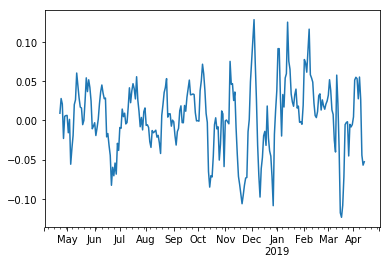

In [122]:
SIGNAL.BA.plot()

In [76]:
lag = 1
period = 5
th = 0.1
# def over_reaction_factor_look_back(lag, period, th):

over_reaction_factor = log_return

for i in range(1,lag+1):
    over_reaction_factor = over_reaction_factor+over_reaction_factor.shift(i)

NEWS_NEG_SENTIMENT_COUNT_POST_MKT = NEWS_NEG_SENTIMENT_COUNT.shift(-1)

NEG_0_1_signal = pd.DataFrame(columns = NEWS_NEG_SENTIMENT_COUNT_POST_MKT.columns)

for date in NEWS_NEG_SENTIMENT_COUNT_POST_MKT.index:
    NEG_0_1_signal.loc[date,:] = NEWS_NEG_SENTIMENT_COUNT_POST_MKT.loc[:date,:].apply(zscore).iloc[-1,:]

NEG_0_1_signal = NEWS_NEG_SENTIMENT_COUNT_POST_MKT.fillna(NEWS_NEG_SENTIMENT_COUNT_POST_MKT.mean()).apply(zscore)

NEG_0_1_signal[NEG_0_1_signal<5] = 0
NEG_0_1_signal[NEG_0_1_signal>5] = 1

NEG_0_1_signal = NEG_0_1_signal.shift(lag)
NEG_0_1_signal[(NEG_0_1_signal==1) & (over_reaction_factor < 0).loc[datetime(2015,1,7):,:]] = 0.5

for i in range(1,period+1):
    NEG_0_1_signal = NEG_0_1_signal + log_return.shift(lag+i)

#     return NEG_0_1_signal

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


TypeError: Must pass DataFrame or 2-d ndarray with boolean values only

In [84]:
NEG_0_1_signal[(NEG_0_1_signal==1) & (over_reaction_factor < 0).loc[datetime(2015,1,7):,:]] = 0.5

In [85]:
for i in range(1,period+1):
    NEG_0_1_signal = NEG_0_1_signal + log_return.shift(lag+i)

In [87]:
# SIGNAL = over_reaction_factor_look_back(1,10,0.1)
SIGNAL = NEG_0_1_signal

In [112]:
transformed_SIGNAL = SIGNAL.copy()
transformed_SIGNAL[transformed_SIGNAL<0.4] = 0
transformed_SIGNAL[transformed_SIGNAL>=0.4] = 1

for i in range(0,len(transformed_SIGNAL.columns)):
    it = 0
    switch =0
    for j in range(0,len(transformed_SIGNAL.index)):
        for k in range(1,10):
            if transformed_SIGNAL.iloc[j-k,i] == 1:
                transformed_SIGNAL.iloc[j,i] = 0

transformed_SIGNAL = transformed_SIGNAL.fillna(0)
transformed_SIGNAL[transformed_SIGNAL == 0] = False
transformed_SIGNAL[transformed_SIGNAL == 1] = True

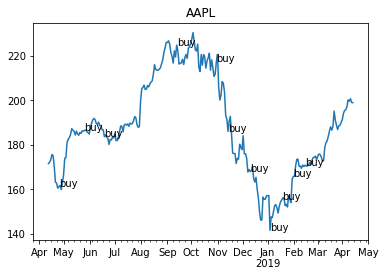

In [116]:
plot('AAPL')

进度: [####################] 100.0% DONE
进度: [####################] 100.0% DONE
进度: [####################] 100.0% DONE
进度: [####################] 100.0% DONE
进度: [####################] 100.0% DONE


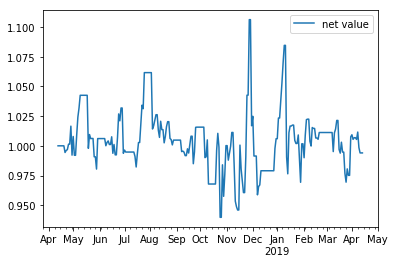

In [114]:
transformed_SIGNAL_copy = transformed_SIGNAL.copy()
small = company_info.index[company_info.marketcap < 250000]
for stock in small:
    transformed_SIGNAL_copy[stock] = False

start_time = datetime(2018,4,21)
end_time = datetime(2019,4,12)

N_long = 2 # number of stocks to long in portfolio
N_short = 10
t = 5 # frequency(day) of adjusting positions
initial_capital = 1 # we have one dollar in pocket to investement

net_value_1 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,16),end_time,initial_capital,N_long,N_short,t)
net_value_2 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,17),end_time,initial_capital,N_long,N_short,t)
net_value_3 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,18),end_time,initial_capital,N_long,N_short,t)
net_value_4 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,19),end_time,initial_capital,N_long,N_short,t)
net_value_5 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,20),end_time,initial_capital,N_long,N_short,t)
# net_value_6 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,21),end_time,initial_capital,N_long,N_short,t)
# net_value_7 = backtest(transformed_SIGNAL_copy.shift(1), datetime(2015,4,22),end_time,initial_capital,N_long,N_short,t)

net_value = (net_value_1 + net_value_2+ net_value_3+ net_value_4+ net_value_5)/5

# print(net_value.iloc[-1,0])
net_value.plot()

In [8]:
def weight(SIGNAL, code, date):
    return SIGNAL.loc[date-BDay(1),code]

In [17]:
def get_price(ticker, start_time, end_time):
    return all_prices.loc[start_time:end_time,ticker]

def update_progress(job_title, progress):
    length = 20 # modify this to change the length
    block = int(round(length*progress))
    msg = "\r{0}: [{1}] {2}%".format(job_title, "#"*block + "-"*(length-block), round(progress*100, 2))
    if progress >= 1: msg += " DONE\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

def portfolio_weight(N_long,N_short):
    long_weight = 1/N_long
    short_weight = 1/N_short
    return long_weight,short_weight

def get_open_price(ticker, start_time, end_time):
    return open_prices.loc[start_time:end_time,ticker]

def portfolio_construct(N_long,N_short,SIGNAL, date, capital):
    weights = pd.DataFrame(index = all_prices.columns)
    
    for code in weights.index:
        weights.loc[code,'weight'] = weight(SIGNAL, code,date)
    
    weights = weights.sort_values('weight', ascending = False)
    
    long_list = np.array(weights.index[:N_long])
    short_list = np.array(weights.index[-N_short:])
    
    long_weight,short_weight = portfolio_weight(N_long,N_short)
    
    long_prices = get_open_price(long_list, date, date)
    
    amount = capital*long_weight/long_prices
    return long_list, short_list, amount

def portfolio_value(long_list, short_list, amount, date):
    long_prices = get_price(long_list, date,date)
#     short_prices = get_prices(short_list, date)
    return np.nansum(np.array(long_prices)*np.array(amount))

# Conduct backtesting and get the net values
def backtest(SIGNAL, start_time,end_time,initial_capital,N_long,N_short,t):
    net_value = pd.DataFrame(index = all_prices.loc[start_time:end_time,:].index)
    it = 0
    long_list = []
    short_list = []
    capital = initial_capital
    update_progress("进度", 0)
    compute_steps = len(net_value.index)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        for date in net_value.index:
            daily_signal = SIGNAL.loc[date,:]
            if (it%t == 0):
                if (daily_signal == 1).sum() != 0:
                    daily_list = list(SIGNAL.columns[daily_signal==1])            

                    long_list = daily_list
                    amount = 1/(len(daily_list)*get_price(long_list, date, date))    
#                     print('bought: ',long_list)
                else:
                    long_list = []
                net_value.loc[date,'net value'] = capital
                it+=1
                    
            else:
                if(len(long_list)!=0):
                    present_value = portfolio_value(long_list, short_list, amount, date)
                    capital = present_value
                else:
                    present_value = capital
                net_value.loc[date,'net value'] = present_value
                it+=1
            update_progress("进度", it/compute_steps)
    
    return net_value
#     net_value['MA5'] = net_value['net value'].rolling(5).mean() # 3-day moving average
#     net_value['MA10'] = net_value['net value'].rolling(10).mean() # 5-day moving average
#     spx = web.DataReader('SPY', 'iex', start_time, end_time).close
#     spx = spx/spx[0]
#     spx.index = pd.to_datetime(spx.index)
#     net_value['S&P 500'] = spx

#     net_value.plot(figsize=(16,8))
#     plt.show()

In [ ]:
returns = pd.DataFrame(index = transformed_SIGNAL.index)
for date in transformed_SIGNAL.index:
    daily_signal = transformed_SIGNAL.loc[date,:]
    if (daily_signal == 1).sum() != 0:
#         print(date, list(transformed_SIGNAL.columns[daily_signal==1]))
        daily_list = list(transformed_SIGNAL.columns[daily_signal==1])
        all_returns = 0
        t = 0
        for item in daily_list:
            all_returns = all_returns + (all_prices.shift(-5).loc[date,item] - all_prices.loc[date,item])/all_prices.loc[date,item]
            t = t+1
        if t!=0:
            returns.loc[date,'return'] = all_returns/t

In [ ]:
def print_buy_list():
    for date in transformed_SIGNAL.index:
        daily_signal = transformed_SIGNAL.loc[date,:]
        if (daily_signal == 1).sum() != 0:
            print(date, list(transformed_SIGNAL.columns[daily_signal==1]))

In [ ]:
print_buy_list()

In [ ]:
company_info.marketcap.median()

In [ ]:
giant = company_info.index[company_info.marketcap>=300000]

In [ ]:
giant

In [ ]:
spx = web.DataReader('SPY', 'iex', start_time, end_time).close
spx = spx/spx[0]
spx.index = pd.to_datetime(spx.index)

In [ ]:
spx.to_excel('SP500.xlsx')

In [ ]:
giant_prices = all_prices.loc[:,giant]

In [ ]:
giant_prices.mean(axis = 1).to_excel('high-cap-performance.xlsx')